In [153]:
MIN_EDGE = 20

OUTPUT_DIR = "/Users/altaf/Projects/dnm_evolution/data/agora/topics"

files = os.listdir(OUTPUT_DIR)[1:40000]

users = bidict()

def get_user_id(user):
    user_id = users.get(user, -1)
    if (user_id < 0):
        user_id = len(users)
        users[user] = user_id
    return(user_id)

edge_list = Counter()

for filename in files:
    topic = json.load(open(os.path.join(OUTPUT_DIR, filename)))
    if len(topic["posters"]) <= 1:
        continue
    
    posters = sorted(topic["posters"])
    for edge in itertools.combinations(posters, 2):
        edge_list[edge] += 1

def get_edge(e):
    return(tuple(sorted([get_user_id(u) for u in e])))
    
edges = {get_edge(e): edge_list[e] for e in edge_list.keys() if edge_list[e] > MIN_EDGE}

len(edges)

494

In [210]:
import os
import json
import math
import itertools
import operator

import networkx as nx
import graph_tool as gt
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import graph_tool.draw
import graph_tool.centrality as gt_centrality

from collections import defaultdict, Counter
from bidict import bidict

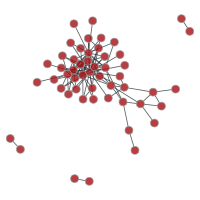

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x118fca290, at 0x100636fd0>

In [121]:
g = gt.Graph(directed = False)
g.add_edge_list(edges)

graph_size = 200
graph_tool.draw.graph_draw(g, output_size=(graph_size, graph_size))

In [154]:
g = gt.Graph(directed=False)
g.add_edge_list(edges)

g.vertex_properties['label'] = g.new_vertex_property('string')
for v in g.vertices():
    g.vertex_properties['label'][v] = users.inv[g.vertex_index[v]]
print('g vert/edges: ',g.num_vertices(), g.num_edges())

#add edge weight property
g.edge_properties['weight'] = g.new_edge_property('double')
g.edge_properties['color'] = g.new_edge_property('vector<double>')
for e in g.edges():
    w = edges[tuple(sorted([e.source(),e.target()]))]
    g.edge_properties['weight'][e] = w
    alpha = (float(w)/max(edge_list.values())) + .025
    g.edge_properties['color'][e] = [103/255.0,134/255.0,239/255.0,alpha]  
    

('g vert/edges: ', 166, 494)


saving to disk...


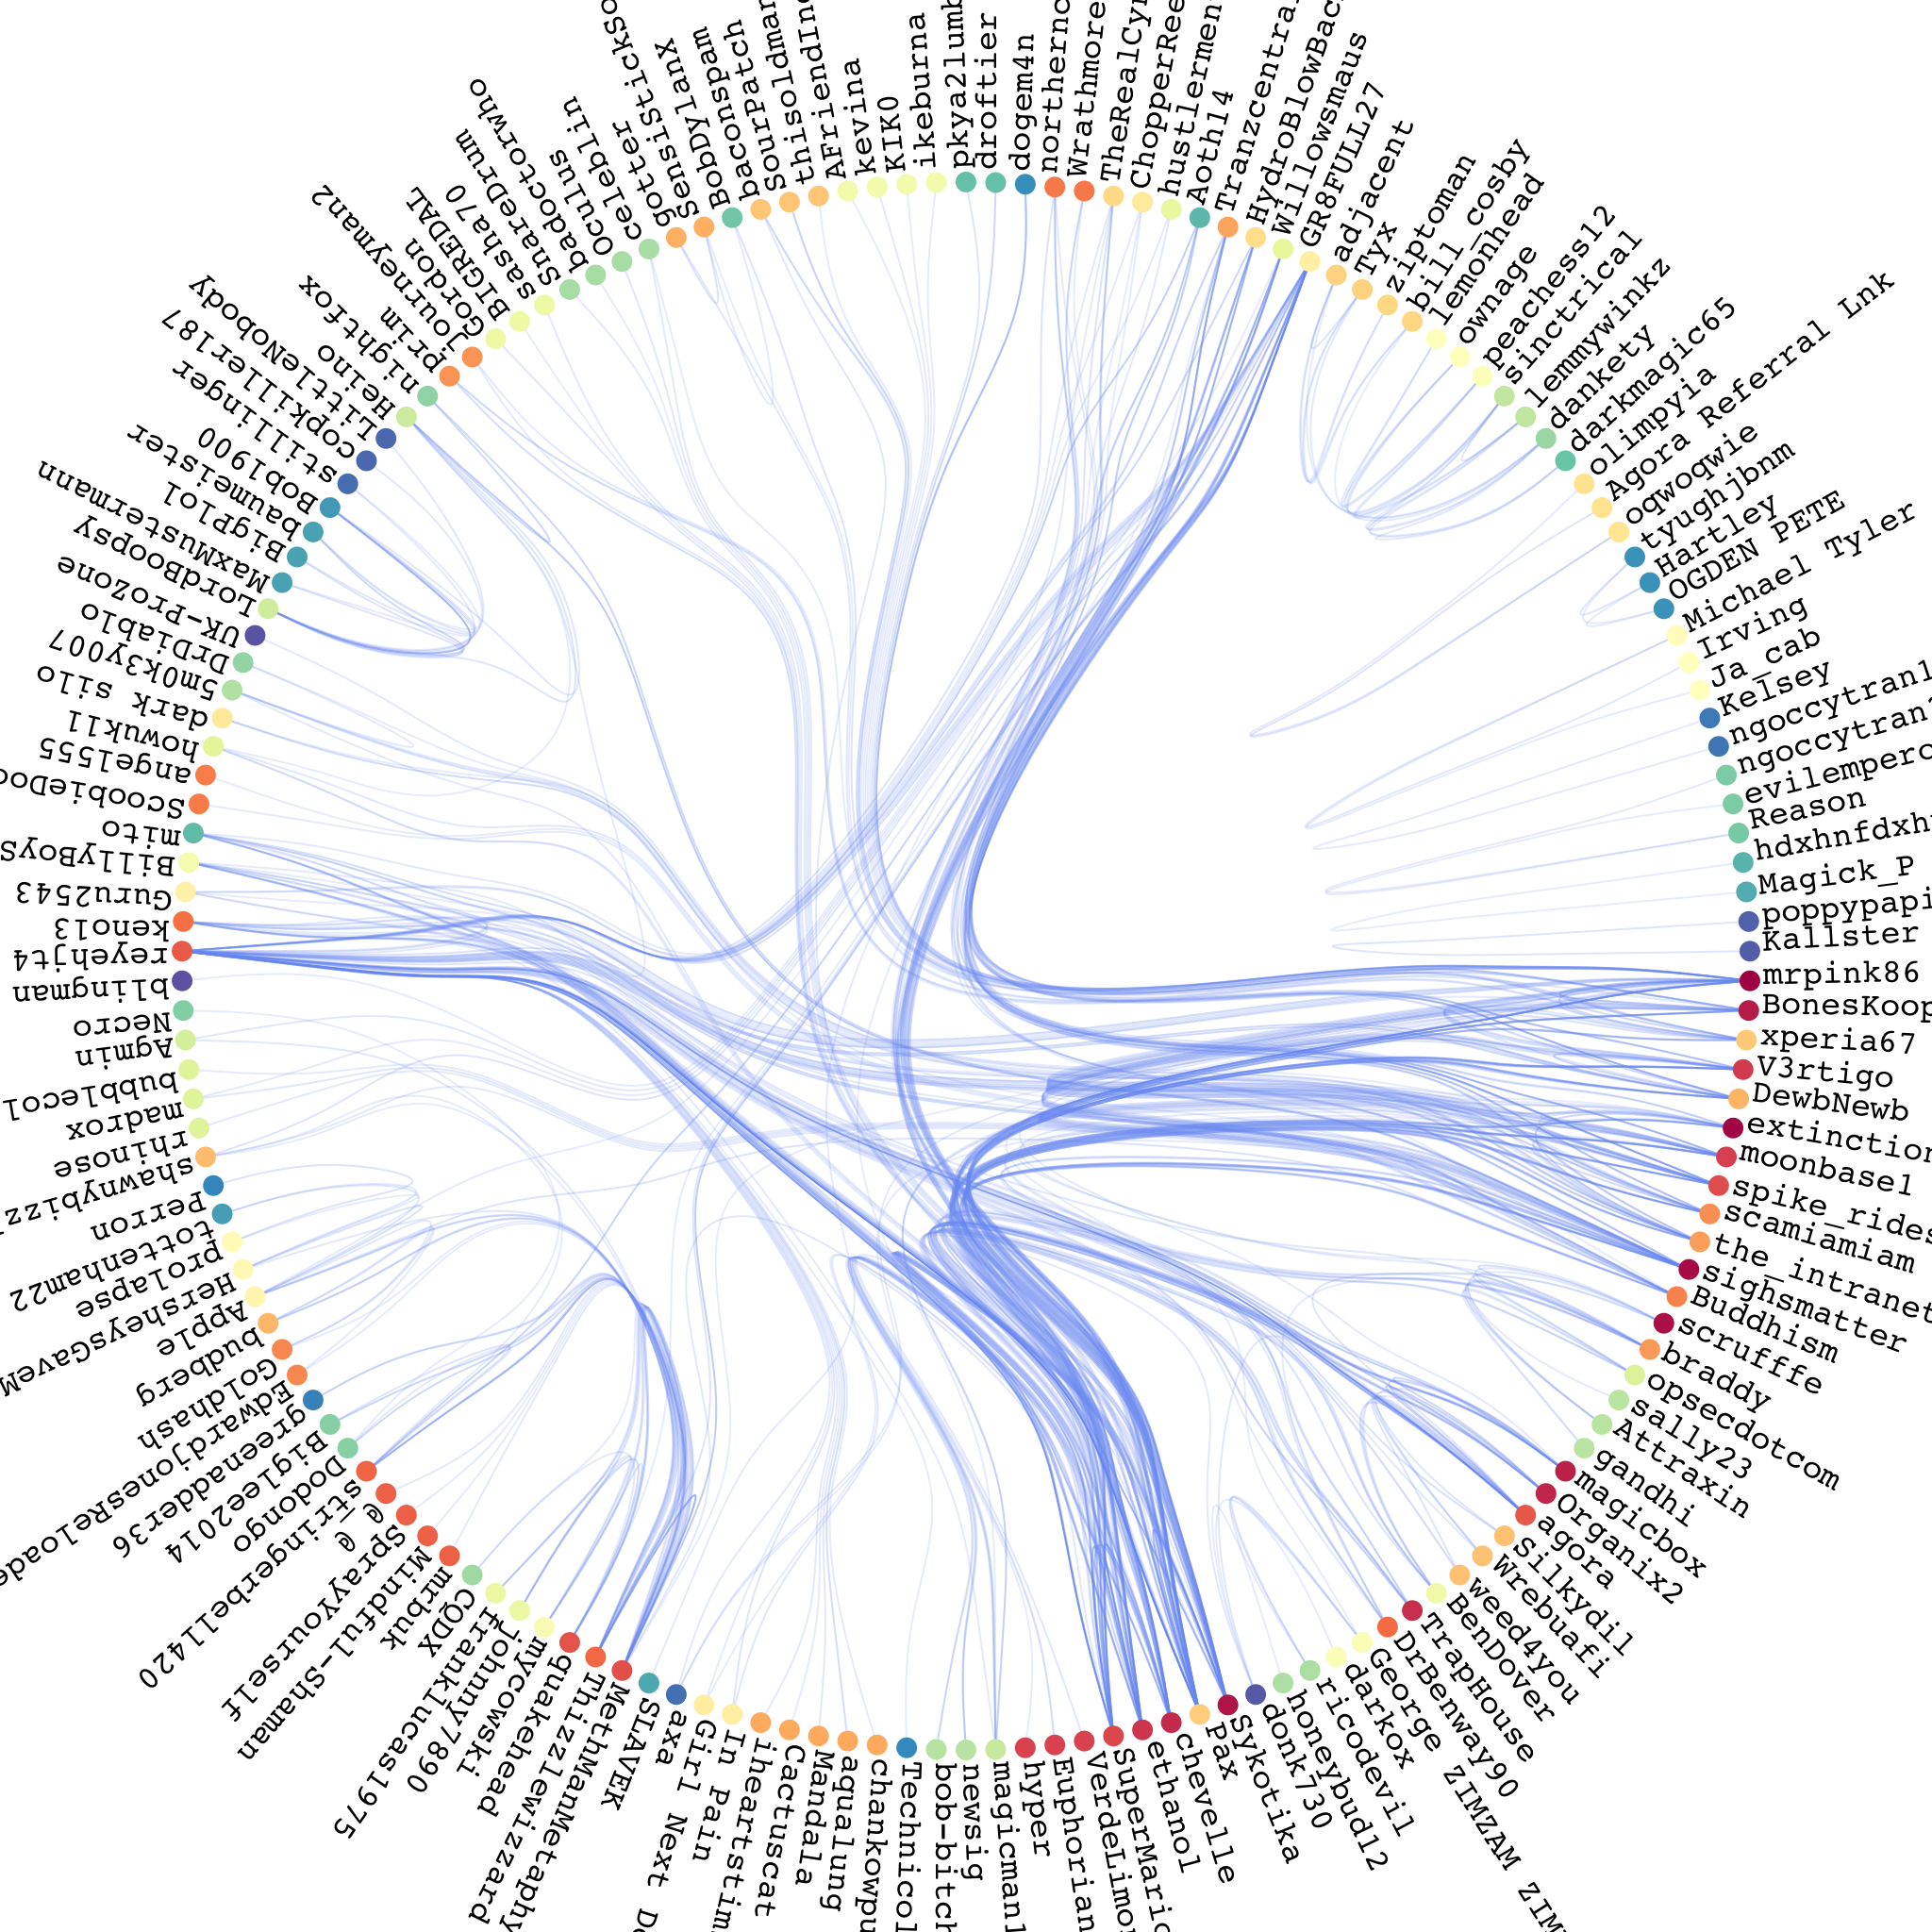

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x119483250, at 0x118fa7ad0>

In [192]:
graph_size = 1024

state = gt.community.minimize_nested_blockmodel_dl(g,deg_corr=False, eweight=g.ep['weight'])
bstack = state.get_bstack()
t = gt.community.get_hierarchy_tree(state)[0]
tpos = pos = gt.draw.radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
cts = gt.draw.get_hierarchy_control_points(g, t, tpos,beta=.87)
pos = g.own_property(tpos)
b = bstack[0].vp["b"]

#text rotation
text_rot = g.new_vertex_property('double')
g.vertex_properties['text_rot'] = text_rot
for v in g.vertices():
    if pos[v][0] >0:
        text_rot[v] = math.atan(pos[v][1]/pos[v][0])
    else:
        text_rot[v] = math.pi + math.atan(pos[v][1]/pos[v][0])

print('saving to disk...')
gt.draw.graph_draw(g, pos=pos, vertex_fill_color=b,
            edge_control_points=cts,
            vertex_size=20,
            vertex_text=g.vertex_properties['label'],
            vertex_text_rotation=g.vertex_properties['text_rot'],
            vertex_text_position=1,
            vertex_font_size=35,
            vertex_font_family='mono',
            vertex_anchor=0,
            vertex_color=b,
            vcmap=matplotlib.cm.Spectral,
            ecmap=matplotlib.cm.Spectral,
            edge_color=g.edge_properties['color'],
            #bg_color=[0,0,0,1],
            output_size=[graph_size*2,graph_size*2],
            output='./data/agora_%d.png' % MIN_EDGE)

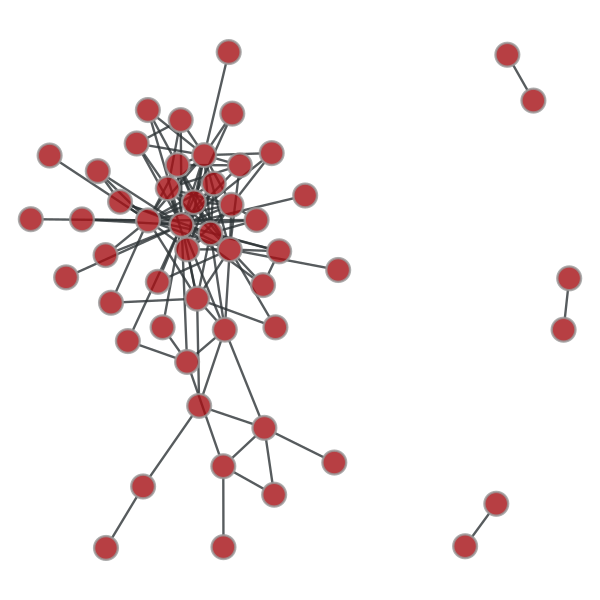

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x119c99350, at 0x118fca050>

In [128]:
MIN_EDGE = 2

OUTPUT_DIR = "/Users/altaf/Projects/dnm_evolution/data/agora/topics"

files = os.listdir(OUTPUT_DIR)[1:400]

users = bidict()

def get_user_id(user):
    user_id = users.get(user, -1)
    if (user_id < 0):
        user_id = len(users)
        users[user] = user_id
    return(user_id)

edge_list = Counter()

for filename in files:
    topic = json.load(open(os.path.join(OUTPUT_DIR, filename)))
    if len(topic["posters"]) <= 1:
        continue
    
    posters = sorted(topic["posters"])
    for edge in itertools.combinations(posters, 2):
        edge_list[edge] += 1

def get_edge(e):
    return(tuple([get_user_id(u) for u in e]))
    
edges = {get_edge(e): edge_list[e] for e in edge_list.keys() if edge_list[e] > MIN_EDGE}

g = gt.Graph(directed = False)
g.add_edge_list(edges.keys())

graph_size = 600
graph_tool.draw.graph_draw(g, output_size=(graph_size, graph_size))

In [207]:
vertex_betweenness, edge_betweenness = gt_centrality.betweenness(g)
ee, x = gt_centrality.eigenvector(g, g.edge_properties["weight"])

#gt.draw.graph_draw(g, vertex_fill_color=x,
#                   vertex_size=gt.draw.prop_to_size(x, mi=5, ma=15),
#                   vcmap=matplotlib.cm.gist_heat,
#                   vorder=x)

vx = dict()
for v in g.vertices():
    vx[g.vertex_properties['label'][v]] = x[v]
    
#z = zip(g.vertex_properties['label'], g.vertex_properties['label'])
#for v in g.vertices():
#    print(x[v])
vx.keys()[1:10]

['prim',
 'stringerbell420',
 'peachess12',
 'madrox',
 'sally23',
 'sinctrical',
 'mrbuk',
 'ChopperReed',
 'Kelsey']

In [220]:
sorted_vertices = sorted(vx.items(), key=operator.itemgetter(1), reverse=True)

EIGEN_VECTOR_CSV = "/Users/altaf/Projects/dnm_evolution/data/agora_eigenvector.csv"

with open(EIGEN_VECTOR_CSV, 'w') as f:
    f.write("user, eigenvector\n")
    for (key, value) in sorted_vertices:
        f.write("%s, %0.3f\n" % (key, value))

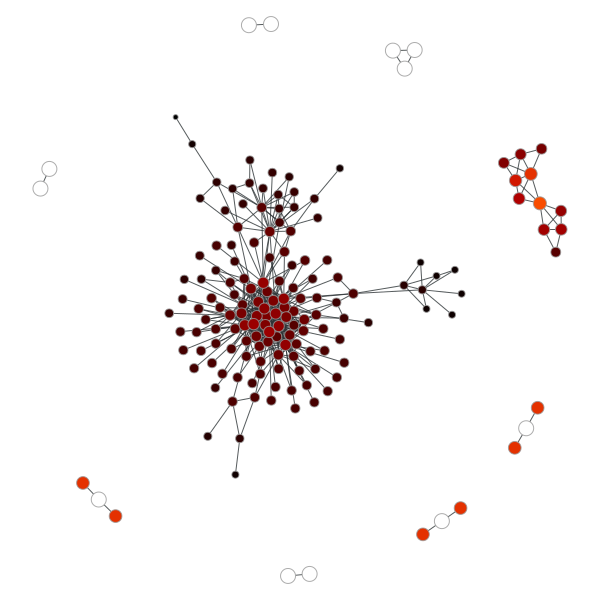

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x119483250, at 0x118fae410>

In [174]:
c = gt_centrality.closeness(g)
gt.draw.graph_draw(g,  vertex_fill_color=c, 
              vertex_size=gt.draw.prop_to_size(c, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat, vorder=c)

In [195]:
a = [1, 3]
b = ["A", "B"]
zip(a, b)

[(1, 'A'), (3, 'B')]